# Data import and feature selection

Import only datetime and precipitation

In [87]:
import pandas as pd

# Load data while preserving raw strings
weather_data = pd.read_csv(
    "../data/raw/weather_data/climate_data/daily/31688.csv",
    usecols=['Station Name', 'Date/Time', 'Total Precip (mm)'],
    dtype={'Date/Time': str}  # Critical for accurate duplicate detection
)

# Clean date strings (remove hidden characters/timezones)
weather_data['Date/Time'] = (
    weather_data['Date/Time']
    .str.strip()  # Remove whitespace
    .str[:10]     # Keep only YYYY-MM-DD (ignore time/timezone if present)
)

# Remove TRUE duplicates (same station + same date)
weather_clean = (
    weather_data
    .drop_duplicates(['Station Name', 'Date/Time'], keep='first')
    .sort_values(['Station Name', 'Date/Time'])
)

# Convert to datetime AFTER deduplication
weather_clean['date'] = pd.to_datetime(weather_clean['Date/Time'], errors='coerce')

# Final validation
assert weather_clean.duplicated(['Station Name', 'date']).sum() == 0
print(f"Cleaned data: {len(weather_clean)} rows ({len(weather_data)-len(weather_clean)} duplicates removed)")

Cleaned data: 6575 rows (72325 duplicates removed)


Check for duplicates

In [88]:
# Identify TRUE duplicates (same station + same timestamp)
dupes = weather_clean.duplicated(subset=['Station Name', 'Date/Time'], keep=False)
print(f"Found {dupes.sum()} true duplicates:")
print(weather_clean[dupes].sort_values(['Station Name', 'Date/Time']).head(10))

# Identify date/time duplucates
dt_dupes = weather_clean.duplicated(subset=['Date/Time'], keep=False)
print(f"Found {dt_dupes.sum()} date/time duplicates:")
print(weather_clean[dt_dupes].sort_values(['Station Name', 'Date/Time']).head(10))

Found 0 true duplicates:
Empty DataFrame
Columns: [Station Name, Date/Time, Total Precip (mm), date]
Index: []
Found 0 date/time duplicates:
Empty DataFrame
Columns: [Station Name, Date/Time, Total Precip (mm), date]
Index: []


Set date/time as index

In [89]:
weather_clean = (
    weather_clean.dropna(subset=['Date/Time'])
    .set_index('Date/Time')
    .sort_index()
)

Rename columns to something more standard

In [90]:
weather_clean.dropna(subset=["Total Precip (mm)"], inplace=True)
weather_clean = weather_clean.rename(columns={
    "Total Precip (mm)": "precip_mm",
    "Station Name": "station_name" 
})

In [91]:
# weather_clean.info()
weather_clean.iloc[0]
weather_clean.head()

,station_name,precip_mm,date
Date/Time,,,
2007-01-01,TORONTO CITY,0.0,2007-01-01
2007-01-02,TORONTO CITY,0.0,2007-01-02
2007-01-03,TORONTO CITY,0.0,2007-01-03
2007-01-04,TORONTO CITY,3.2,2007-01-04
2007-01-05,TORONTO CITY,6.4,2007-01-05


Write to file

In [92]:
import re

# Get and format beach name
stn_name = weather_clean.iloc[0]['station_name'] # Assuming only one beach name at a time 
stn_name = stn_name.lower().replace(" ", "_")
stn_name = re.sub(f'[^a-z0-9_]', "", stn_name)

print(stn_name)
# Write to file 
weather_clean.to_parquet(f"..\\data\\cleaned\\cleaned_{stn_name}.parquet")

toronto_city


# Data Exploration

In [62]:
import matplotlib.pyplot as plt

Rainfall exploration

In [63]:
has_precip = weather_data['Total Precip (mm)'] > 0 # 11892 entries in Toronto City
weather_data.loc[has_precip]

,Station Name,Date/Time,Total Precip (mm)
3,TORONTO CITY,2007-01-04,3.2
4,TORONTO CITY,2007-01-05,6.4
5,TORONTO CITY,2007-01-06,5.0
6,TORONTO CITY,2007-01-07,0.8
7,TORONTO CITY,2007-01-08,1.8
...,...,...,...
78895,TORONTO CITY,2024-12-27,0.2
78896,TORONTO CITY,2024-12-28,0.9
78897,TORONTO CITY,2024-12-29,23.2
78898,TORONTO CITY,2024-12-30,2.3


Plot date vs. precipitation

In [64]:
weather_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6423 entries, 2007-01-01 to 2024-12-31
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Station Name       6423 non-null   object        
 1   Total Precip (mm)  6423 non-null   float64       
 2   date               6423 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 458.8+ KB


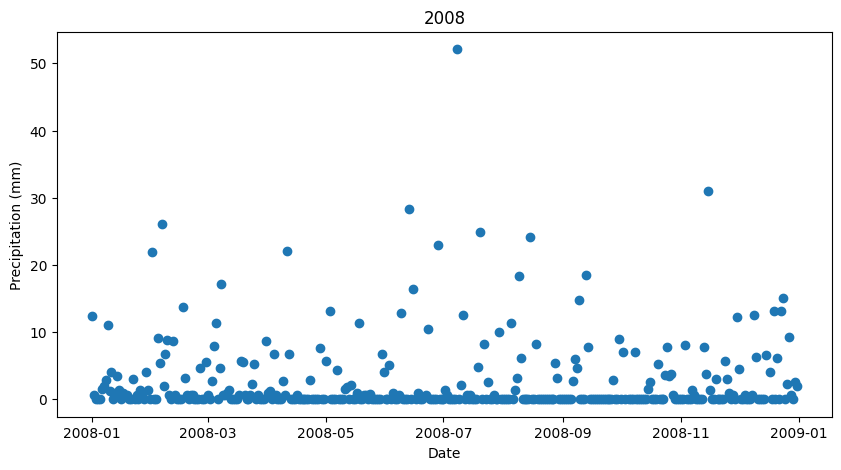

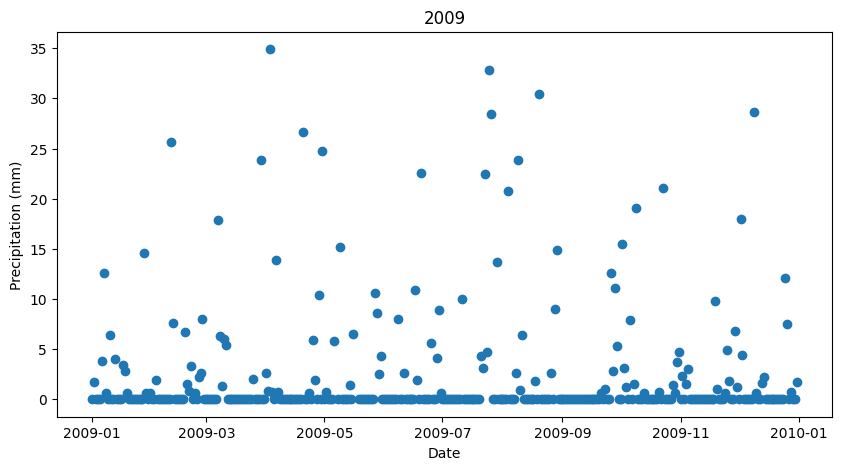

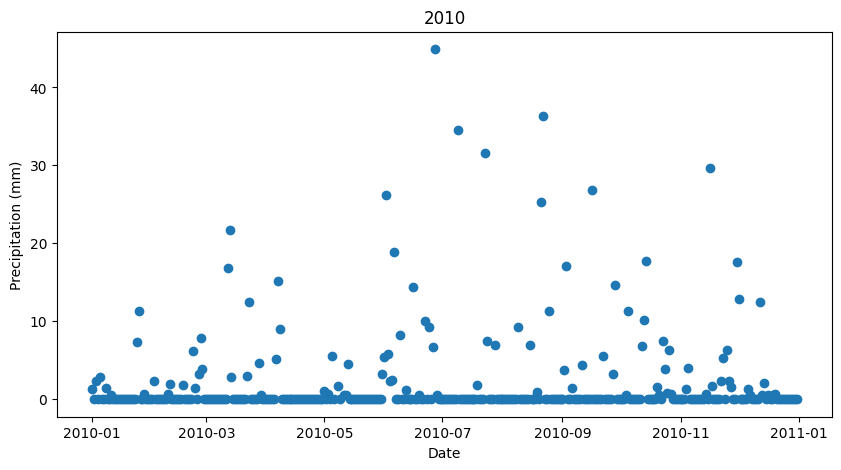

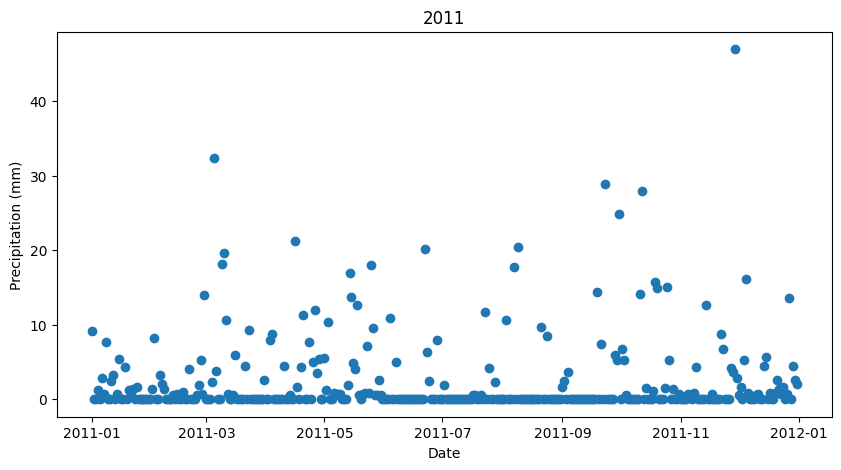

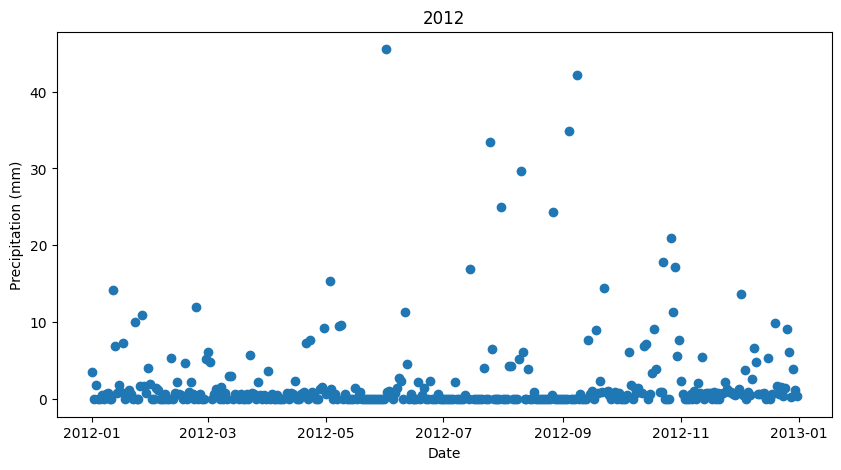

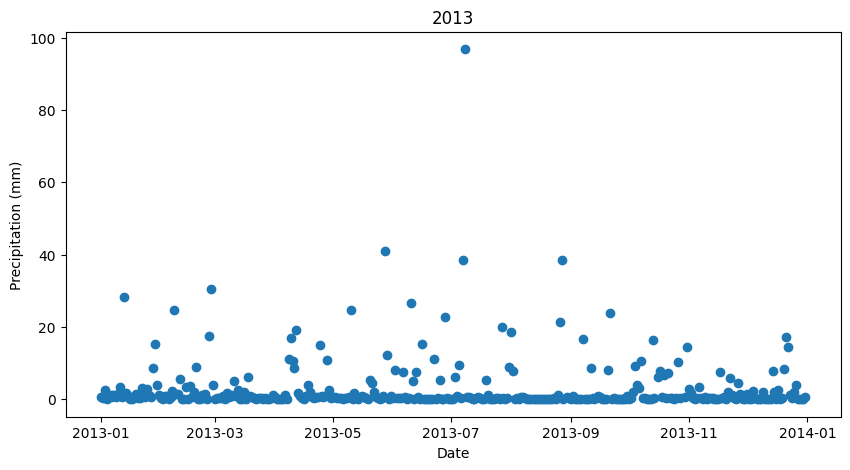

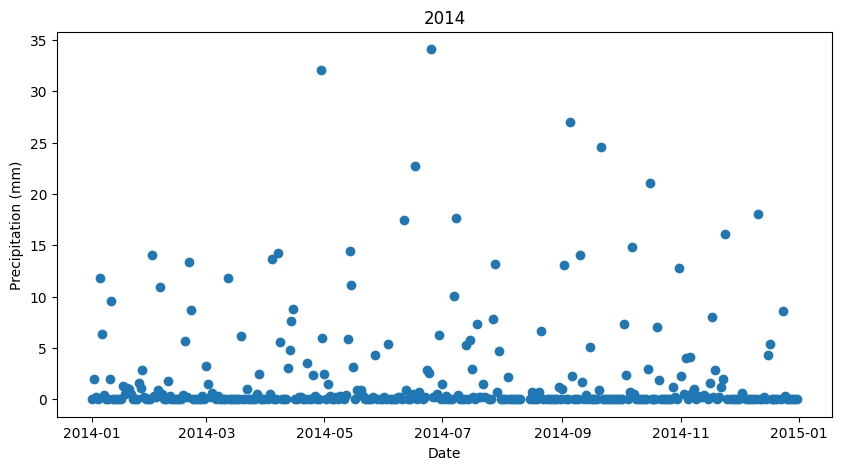

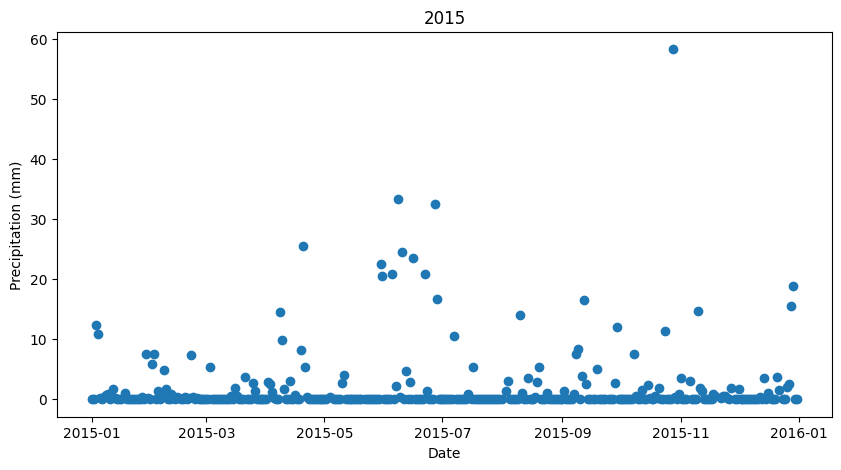

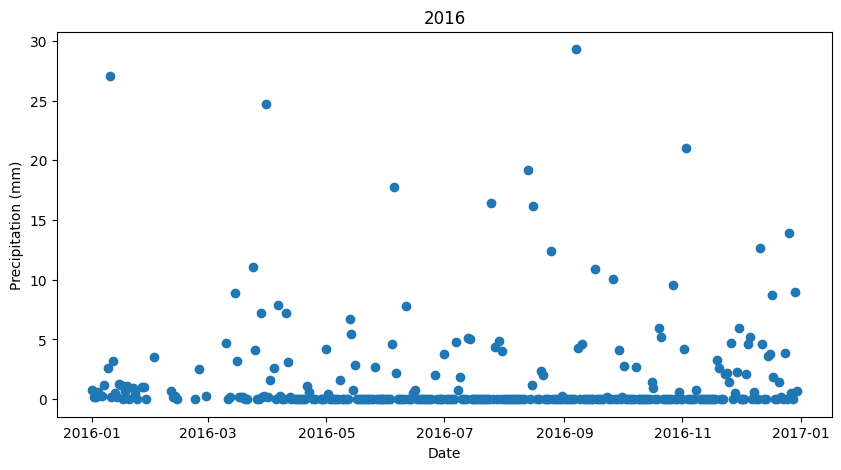

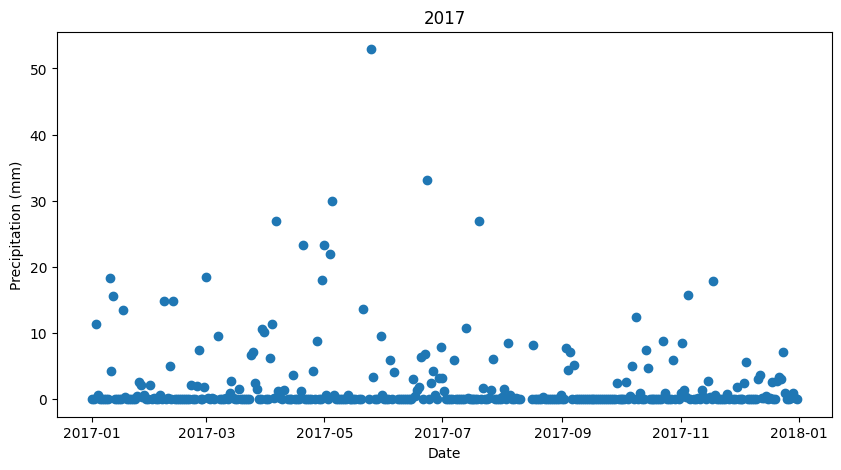

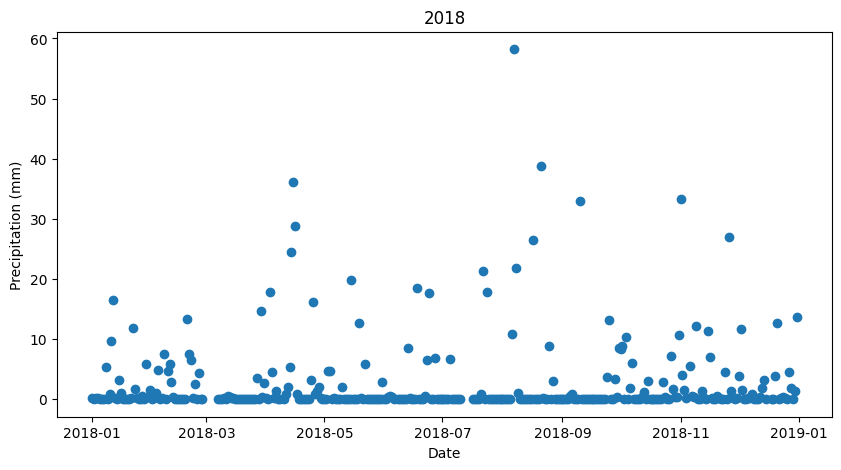

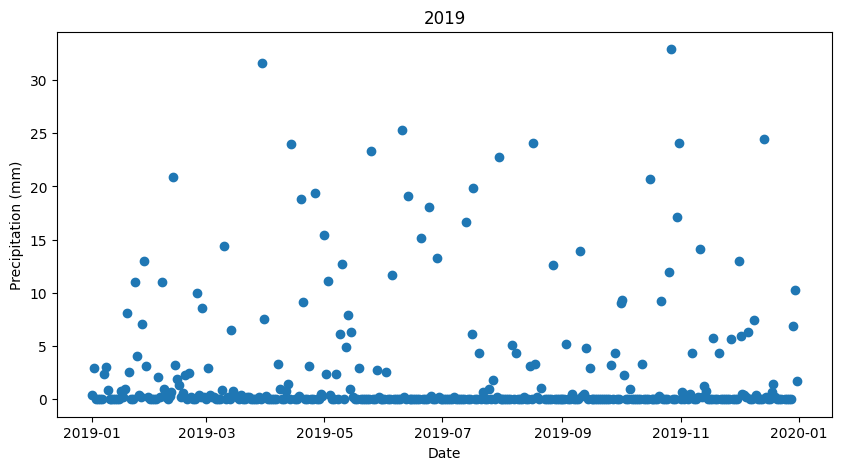

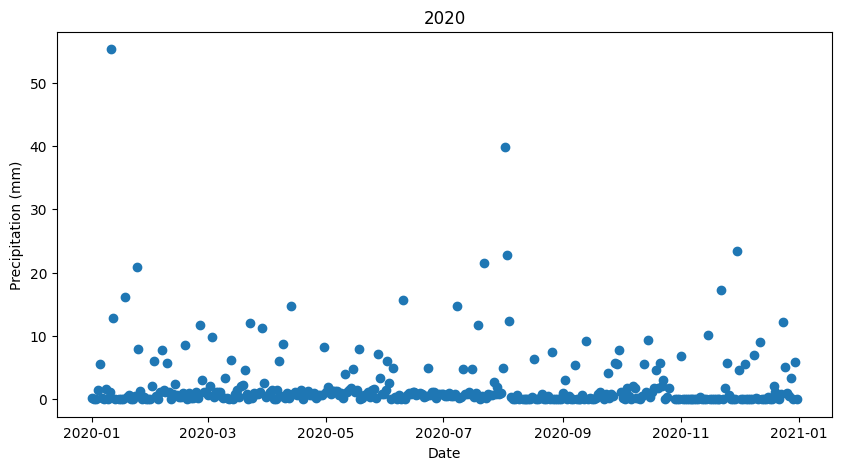

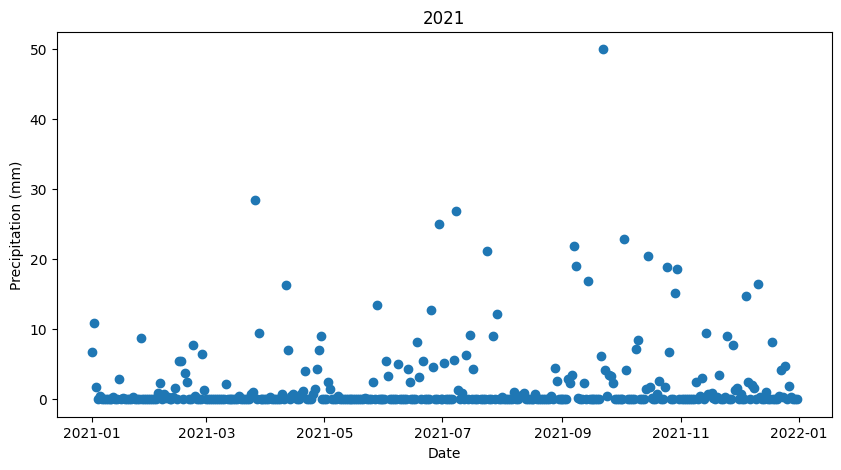

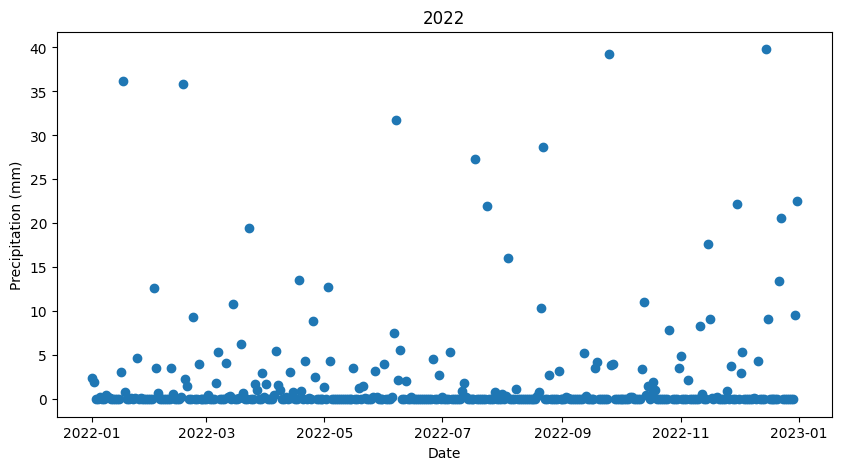

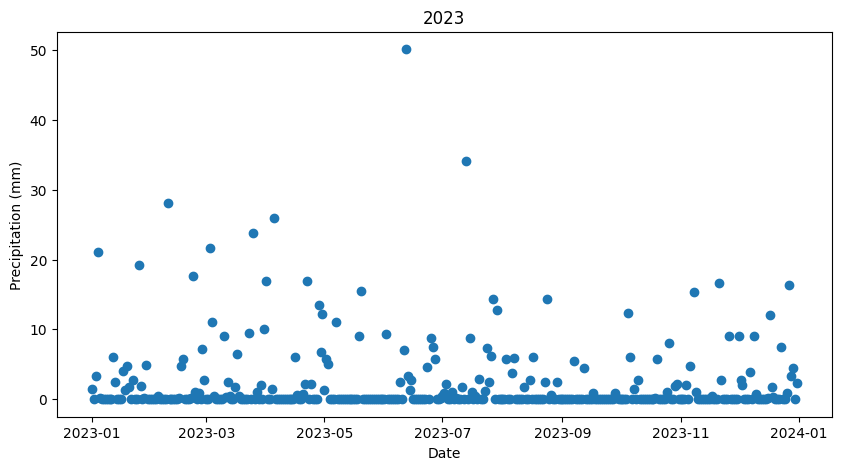

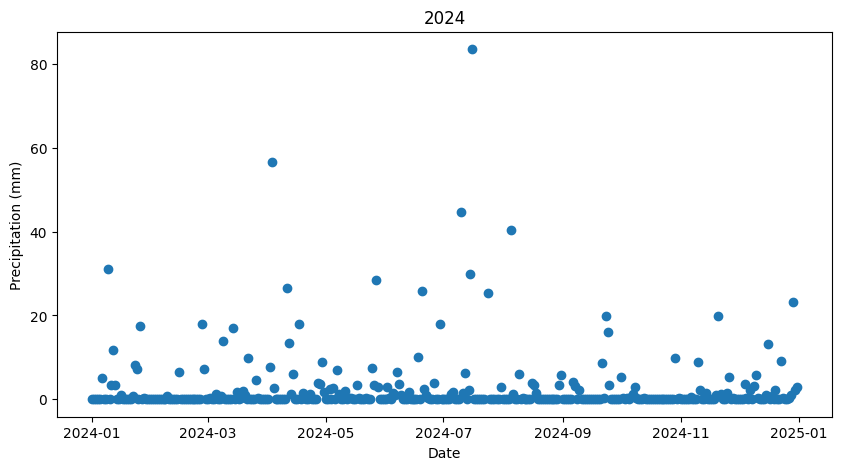

In [65]:
for i in range(2008, 2025):
    plt.figure(figsize=(10,5))
    mask = weather_clean['date'].dt.year == i
    plt.scatter(weather_clean['date'].loc[mask], weather_clean['Total Precip (mm)'].loc[mask])
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.title(f'{i}')
    plt.show()

In [66]:
# Inspect ecoli anomaly 